In [1]:
! pip install yfinance

     |████████████████████████████████| 5.5MB 3.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=d2c811edde4a29d8dbcf8b7fead9684fe0bd0d868df4959558bca4e403daed35
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# Load packages

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
from datetime import datetime
import yfinance

from matplotlib.widgets import Slider, Button, RadioButtons
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from statsmodels.formula.api import ols
import re

from IPython.display import display_html

from google.colab import drive
drive.mount('/content/drive/')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
cd 'drive/My Drive/DS4A - Team 23'

In [ ]:
from mergeStock import mergeYahoo

In [ ]:
df = mergeYahoo("TSLA")

In [ ]:
# feature engineering function 
def feature_eng(df):
  # creating the new variable: leading_sentiment 
  for index, row in df.iterrows():
    if row["pos_count"] - row["neg_count"] > 0:
      df.at[index, "leading_sentiment"] = "positive"
    elif row['pos_count'] - row["neg_count"] == 0:
      df.at[index, "leading_sentiment"] = "neutral"
    else:
      df.at[index, "leading_sentiment"] = "negative"
    
    df["leading_sentiment"] = pd.Categorical(df.leading_sentiment, categories = ["positive", "neutral", "negative"])

  # creating the new variable: volatility_type
  for index, row in df.iterrows():
    if row["VIX Close"] >= 30:
      df.at[index, "volatility_type"] = "high volatility"
    elif row['VIX Close'] > 20 and row['VIX Close'] < 30:
      df.at[index, "volatility_type"] = "mid volatility"
    else:
      df.at[index, "volatility_type"] = "low volatility"

  df["volatility_type"] = pd.Categorical(df.volatility_type, categories = ["high volatility", "mid volatility", "low volatility"])

  df["Y"] = pd.Categorical(df.Y, categories = [1,0])

  # standardize numeric data
  df["Volume"] = (df["Volume"]-df["Volume"].mean())/df["Volume"].std()
  df["pos_sum"] = (df["pos_sum"] - df["pos_sum"].mean())/df["pos_sum"].std()
  df["neg_sum"] = (df["neg_sum"] - df["neg_sum"].mean())/df["neg_sum"].std()
  df['comment_count'] = (df["comment_count"] - df["comment_count"].mean())/df["comment_count"].std()

  return df 

def eda(ticker, df):
  # fourier transform of pos_sentiment 
  df_1 = df[["pos_mean", "Close"]]
  close_fft = np.fft.fft(np.asarray(df_1['pos_mean'].tolist()))
  fft_df = pd.DataFrame({'fft':close_fft})
  fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
  fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
  fft_list = np.asarray(fft_df['fft'].tolist())

  for num_ in [5, 10, 15, 20]:
      fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
      df_1['fourier '+str(num_)]=np.fft.ifft(fft_list_m10)

  # fourier transform of neg_sentiment 
  df_2 = df[["neg_mean", "Close"]]
  close_fft = np.fft.fft(np.asarray(df_2['neg_mean'].tolist()))
  fft_df = pd.DataFrame({'fft':close_fft})
  fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
  fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
  fft_list = np.asarray(fft_df['fft'].tolist())

  for num_ in [5, 10, 15, 20]:
      fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
      df_2['fourier '+str(num_)]=np.fft.ifft(fft_list_m10)
  # plot pos & neg sentiment scores against stock price 

  # plot for fourier 20
  fig, ax=plt.subplots(2,1, figsize=(16,10))
  df_1[["Close","fourier 20"]].plot(secondary_y = "Close", ax = ax[0], title = "positive sentiment score vs. stock close price (post fourier transform) for " + ticker)
  df_2[["Close","fourier 20"]].plot(secondary_y = "Close", ax = ax[1], title = "negative sentiment score vs. stock close price (post fourier transform) for " + ticker)

In [ ]:
df = feature_eng(df)
df.head()

In [ ]:
df.shape

In [ ]:
eda("TSLA", df)

In [ ]:
def get_ct_stra(stra_var):
    ct_stra = pd.crosstab(index=[stra_var,df["leading_sentiment"]], columns = df.Y, margins = True)
    ct_stra['Up days(%)'] = round(ct_stra[1]/ct_stra['All']*100,2)
    return ct_stra.drop(columns='All').drop('All', level=0)
get_ct_stra(df["volatility_type"])

In [ ]:
df_1 = df.copy()
df_1["Y"] = df_1.Y.cat.codes
df_1["leading_sentiment"] = df_1.leading_sentiment.cat.codes
df_1["volatility_type"] = df_1.volatility_type.cat.codes

tar_var = df_1["Y"]
#exp_var = df_1[["Volume", "returnClosePrev1", "returnClosePrev5", "returnOpenPrev1", "returnOpenPrev5", "pos_mean", "neg_mean", "leading_sentiment", "vix_returnPrev1", "comment_count"]]
exp_var = df_1[["Volume", "returnClosePrev1", "returnClosePrev5", "returnOpenPrev1", "returnOpenPrev5", "pos_mean", "neg_mean", "leading_sentiment", "vix_returnPrev1"]]

#logit_model = sm.Logit(tar_var, exp_var)
#m = logit_model.fit_regularized(method = "l1")
#print(m.summary())

In [ ]:
exp_var.shape

In [ ]:
train_size = int(round(df_1.shape[0] * 0.8))
xtrain, xtest = exp_var[0:train_size], exp_var[train_size:]
ytrain, ytest = tar_var[0:train_size], tar_var[train_size:]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

In [ ]:
grid_params = {'C':np.logspace(-5, 5, 15), 'penalty':['l2'], 'fit_intercept':[True, False], 'max_iter':[100000], 'verbose':[1]}

In [ ]:
xtest.head()

In [ ]:
logreg = LogisticRegression()
grid_acc = GridSearchCV(logreg, param_grid=grid_params, scoring = 'precision')
grid_acc.fit(xtrain, ytrain)

ypred = grid_acc.predict(xtest)

print('Accuracy Score: ' + str(accuracy_score(ytest, ypred)))
print('Precision Score: ' + str(precision_score(ytest, ypred)))
print('Recall Score: ' + str(recall_score(ytest, ypred)))
print('F1 Score: ' + str(f1_score(ytest, ypred)))

In [ ]:
logreg = LogisticRegression()
logreg.fit(xtrain, ytrain)

In [ ]:
lr_feature_df = pd.DataFrame.from_dict({"Features": xtrain.columns,"Coefs": logreg.coef_[0]})

lr_feature_df['Colors'] = lr_feature_df['Coefs'].apply(lambda coef: 'red' if coef < 0 else sns.xkcd_rgb["medium green"])
lr_feature_df = lr_feature_df.sort_values('Coefs', ascending = True).reset_index(drop = True)


In [ ]:
lr_feature_df

In [ ]:
plt.figure(figsize = (14, 10), dpi = 80)
plt.hlines(y = lr_feature_df.index, xmin = 0, xmax = lr_feature_df['Coefs'],
           color = lr_feature_df['Colors'], alpha = 0.7, linewidth = 5)
plt.xlabel(xlabel = "Beta Coefficient Values", size = 15, x = 1.05)
plt.ylabel(ylabel = "Features", size = 25, rotation = 0, y = 1.01)
plt.yticks(lr_feature_df.index, lr_feature_df["Features"], fontsize = 12)
plt.title("Feature Importance from Logistic Regression", fontsize = 20, y = 1.05)
plt.grid(linestyle = "--", alpha = 0.5)

In [ ]:
y_pred = logreg.predict(xtest)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(xtest, ytest)))

Accuracy of logistic regression classifier on test set: 0.61


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.84      0.70        62
           1       0.63      0.33      0.44        51

    accuracy                           0.61       113
   macro avg       0.62      0.59      0.57       113
weighted avg       0.62      0.61      0.58       113



In [ ]:
cf_matrix = confusion_matrix(ytest, y_pred)
print(cf_matrix)

[[52 10]
 [34 17]]


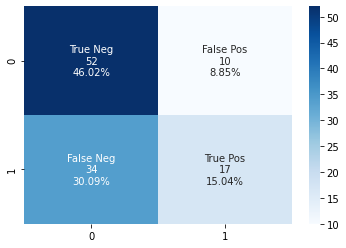

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [ ]:
logit_model = sm.Logit(ytrain, xtrain)
m = logit_model.fit_regularized(method = "l1")
print(m.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6891595477962141
            Iterations: 78
            Function evaluations: 78
            Gradient evaluations: 78
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                  451
Model:                          Logit   Df Residuals:                      441
Method:                           MLE   Df Model:                            9
Date:                Thu, 15 Oct 2020   Pseudo R-squ.:                0.005580
Time:                        01:46:31   Log-Likelihood:                -310.81
converged:                       True   LL-Null:                       -312.56
Covariance Type:            nonrobust   LLR p-value:                    0.9418
                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
ytest

2019-09-30    1
2019-10-01    1
2019-10-02    0
2019-10-03    0
2019-10-04    1
             ..
2020-08-07    1
2020-08-10    1
2020-08-11    0
2020-08-12    1
2020-08-13    1
Name: Y, Length: 214, dtype: int8

In [ ]:
y_pred

2019-09-30    0.506939
2019-10-01    0.316931
2019-10-02    0.419704
2019-10-03    0.509290
2019-10-04    0.561458
                ...   
2020-08-07    0.629802
2020-08-10    0.622640
2020-08-11    0.504873
2020-08-12    0.469548
2020-08-13    0.266656
Length: 214, dtype: float64

In [ ]:
y_pred = m.predict(xtest)
y_pred = (y_pred>np.log(0.5/(1-0.5))).astype('int')
cf_matrix = confusion_matrix(ytest,y_pred)
print(cf_matrix)

[[  0 119]
 [  0  95]]


In [ ]:
#This function calculates the TPR and TNR for given p
b_Volume = 0.036
b_returnClosePrev1 = -2.8835
b_returnClosePrev5 = 2.9152
b_returnOpenPrev1 = -3.5529
b_returnOpenPrev5 = -2.1151
b_pos_mean = 0.0465
b_neg_mean = 0.1211
b_leading_sentiment = -0.1867
b_vix_returnPrev1 = -3.4777
b_comment_count = 0.1942

def rates(p):
    a= df_1.Y
    b=(b_Volume*df_1['Volume']+b_returnClosePrev1*df_1['returnClosePrev1'] + b_returnClosePrev5*df_1["returnClosePrev5"] + 
       b_returnOpenPrev1*df_1["returnOpenPrev1"] + b_returnOpenPrev5*df_1["returnOpenPrev5"] + b_pos_mean*df_1["pos_mean"] + 
       b_neg_mean*df_1["neg_mean"] + b_leading_sentiment*df_1["leading_sentiment"] + b_vix_returnPrev1*df_1["vix_returnPrev1"] + 
       b_comment_count*df_1["comment_count"]>np.log(p/(1-p))).astype('int')
    
    TPR=(a & b).sum(axis=0)/a.sum(axis=0)
    TNR=(1-a & 1-b).sum(axis=0)/(1-a).sum(axis=0)
    return [TPR,TNR]

#Then, we use this function to plot the ROC curve
x=[]
y=[]
for p in np.arange(0.01,0.99,0.01):
    z=rates(p)
    y.append(z[0])
    x.append(1-z[1])
    
fig, ax = plt.subplots()

ax.plot(x,y, label='ROC curve for Logistic Model for TSLA')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Stock Movement')
plt.legend(loc='lower right')

NameError: ignored

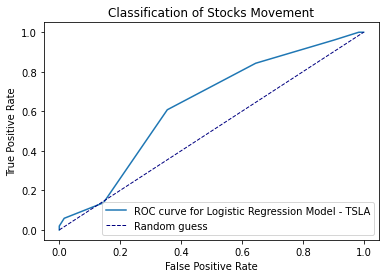

In [ ]:
#This function calculates the TPR and TNR for given p
def rates(p):
    a= ytest
    b=(m.predict(xtest)>np.log(p/(1-p))).astype('int')
    
    TPR=(a & b).sum(axis=0)/a.sum(axis=0)
    TNR=(1-a & 1-b).sum(axis=0)/(1-a).sum(axis=0)
    return [TPR,TNR]

#Then, we use this function to plot the ROC curve
x=[]
y=[]
for p in np.arange(0.01,0.99,0.01):
    z=rates(p)
    y.append(z[0])
    x.append(1-z[1])
    
fig, ax = plt.subplots()

ax.plot(x,y, label='ROC curve for Logistic Regression Model - TSLA')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Stocks Movement')
plt.legend(loc='lower right')

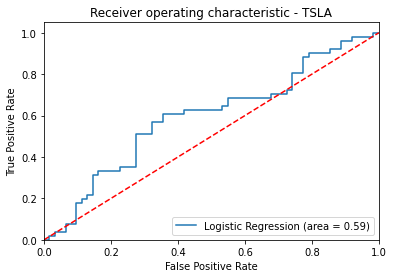

In [ ]:
logit_roc_auc = roc_auc_score(ytest, logreg.predict(xtest))
fpr, tpr, thresholds = roc_curve(ytest, logreg.predict_proba(xtest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - TSLA')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
def logreg_model(ticker):
  df = mergeYahoo(ticker) # load data
  df = feature_eng(df) # feature engineering
  df_1 = df.copy() # set target variables and explanatory variables
  df_1["Y"] = df_1.Y.cat.codes
  df_1["leading_sentiment"] = df_1.leading_sentiment.cat.codes
  df_1["volatility_type"] = df_1.volatility_type.cat.codes

  tar_var = df_1["Y"]
  exp_var = df_1[["Volume", "returnClosePrev1", "returnClosePrev5", "returnOpenPrev1", "returnOpenPrev5", "pos_mean", "neg_mean", "leading_sentiment", "vix_returnPrev1", "comment_count"]]
  train_size = int(round(df_1.shape[0] * 0.8))
  xtrain, xtest = exp_var[0:train_size], exp_var[train_size:] # test-train set split
  ytrain, ytest = tar_var[0:train_size], tar_var[train_size:] 
  logreg = LogisticRegression() # fit the model
  logreg.fit(xtrain, ytrain)
  accuracy = logreg.score(xtest, ytest)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy))
  return accuracy


In [ ]:
top_30_stocks_list = pd.read_csv("/content/drive/My Drive/DS4A - Team 23/data/top_30_summary_python_new.csv")
top_30_stocks_list.sort_values(by = "comment_counts")

,ticker,current_price,sector,long_name,keywords,comment_counts
16,HEXO,0.750000,Healthcare,HEXO,{'HEXO'},20
29,ZNGA,9.300000,Communication Services,Zynga,"{'Zynga', 'ZNGA'}",41
25,TOPS,1.190000,Industrials,Top Ships,"{'Top Ships', 'TOPS'}",44
15,GPRO,6.210000,Technology,GoPro,"{'GoPro', 'GPRO'}",63
22,PLUG,17.879999,Industrials,Plug Power,"{'PLUG', 'Plug Power'}",84
13,FIT,6.870000,Technology,Fitbit,"{'Fitbit', 'FIT'}",163
0,AAL,13.160000,Industrials,American Airlines,"{'American Airlines', 'AAL'}",167
9,DAL,32.680000,Industrials,Delta Air Lines,"{'Delta Air Lines', 'delta', 'DAL'}",233
2,ACB,5.100000,Healthcare,Aurora Cannabis,"{'ACBFF', 'ACB', 'Aurora Cannabis'}",254
7,CGC,17.629999,Healthcare,Canopy Growth,"{'Canopy Growth', 'CGC'}",302


In [ ]:
tickers

['AAL',
 'AAPL',
 'ACB',
 'AMD',
 'AMZN',
 'BABA',
 'BAC',
 'CGC',
 'CRON',
 'DAL',
 'DIS',
 'F',
 'FB',
 'FIT',
 'GE',
 'GPRO',
 'HEXO',
 'MSFT',
 'NFLX',
 'NIO',
 'NKLA',
 'NVDA',
 'PLUG',
 'SBUX',
 'SNAP',
 'TOPS',
 'TSLA',
 'TWTR',
 'UBER',
 'ZNGA']

In [ ]:
df = mergeYahoo("UBER")

[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


In [ ]:
acc_dic = {}
for ticker in tickers:
  acc = logreg_model(ticker)
  print(ticker, " ", acc)
  acc_dic[ticker] = acc

[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.59
AAL   0.5929203539823009
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.58
AAPL   0.5752212389380531
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.60
ACB   0.5978260869565217
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.51
AMD   0.5132743362831859
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.61
AMZN   0.6106194690265486
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.48
BABA   0.4778761061946903
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.42
BAC   0.415929203539823
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.56
CGC   0.5636363636363636
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.54
CRON   0.5398230088495575
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.48
DAL   0.4778761061946903
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.53
DIS   0.5309734513274337
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.52
F   0.5221238938053098
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.57
FB   0.5663716814159292
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.54
FIT   0.5398230088495575
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.53
GE   0.5309734513274337
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.52
GPRO   0.5221238938053098
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.62
HEXO   0.6233766233766234
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.59
MSFT   0.5929203539823009
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.51
NFLX   0.5132743362831859
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.42
NIO   0.42105263157894735
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.30
NKLA   0.3
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.57
NVDA   0.5663716814159292
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.60
PLUG   0.6017699115044248
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.46
SBUX   0.46017699115044247
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.50
SNAP   0.504424778761062
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 1.00
TOPS   1.0
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.60
TSLA   0.6017699115044248
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.54
TWTR   0.5398230088495575
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.53
UBER   0.532258064516129
[*********************100%***********************]  1 of 1 completed


/content/drive/My Drive/DS4A - Team 23/mergeStock.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['close_T-1'] = price_df.Close.shift(periods =1)
/content/drive/My Drive/DS4A - Team 23/mergeStock.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Y']= price_df.apply(lambda x: 1 if (x['Close'] - x['close_T-1']) > 0 else 0, axis=1).shift(periods =-1)


Accuracy of logistic regression classifier on test set: 0.55
ZNGA   0.5486725663716814


In [ ]:
acc_dic

{'AAL': 0.5929203539823009,
 'AAPL': 0.5752212389380531,
 'ACB': 0.5978260869565217,
 'AMD': 0.5132743362831859,
 'AMZN': 0.6106194690265486,
 'BABA': 0.4778761061946903,
 'BAC': 0.415929203539823,
 'CGC': 0.5636363636363636,
 'CRON': 0.5398230088495575,
 'DAL': 0.4778761061946903,
 'DIS': 0.5309734513274337,
 'F': 0.5221238938053098,
 'FB': 0.5663716814159292,
 'FIT': 0.5398230088495575,
 'GE': 0.5309734513274337,
 'GPRO': 0.5221238938053098,
 'HEXO': 0.6233766233766234,
 'MSFT': 0.5929203539823009,
 'NFLX': 0.5132743362831859,
 'NIO': 0.42105263157894735,
 'NKLA': 0.3,
 'NVDA': 0.5663716814159292,
 'PLUG': 0.6017699115044248,
 'SBUX': 0.46017699115044247,
 'SNAP': 0.504424778761062,
 'TOPS': 1.0,
 'TSLA': 0.6017699115044248,
 'TWTR': 0.5398230088495575,
 'UBER': 0.532258064516129,
 'ZNGA': 0.5486725663716814}

In [ ]:
acc_dic

[('NKLA', 0.3),
 ('BAC', 0.415929203539823),
 ('NIO', 0.42105263157894735),
 ('SBUX', 0.46017699115044247),
 ('BABA', 0.4778761061946903),
 ('DAL', 0.4778761061946903),
 ('SNAP', 0.504424778761062),
 ('AMD', 0.5132743362831859),
 ('NFLX', 0.5132743362831859),
 ('F', 0.5221238938053098),
 ('DIS', 0.5309734513274337),
 ('GE', 0.5309734513274337),
 ('UBER', 0.532258064516129),
 ('CRON', 0.5398230088495575),
 ('FIT', 0.5398230088495575),
 ('TWTR', 0.5398230088495575),
 ('CGC', 0.5636363636363636),
 ('FB', 0.5663716814159292),
 ('NVDA', 0.5663716814159292),
 ('AAPL', 0.5752212389380531),
 ('AAL', 0.5929203539823009),
 ('MSFT', 0.5929203539823009),
 ('ACB', 0.5978260869565217),
 ('TSLA', 0.6017699115044248),
 ('AMZN', 0.6106194690265486)]